In [404]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Climate Change/Full_Corporations_Response_Data_Dictionary copy.csv
/kaggle/input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Climate Change/2020_Full_Climate_Change_Dataset.csv
/kaggle/input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Climate Change/2019_Full_Climate_Change_Dataset.csv
/kaggle/input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Climate Change/2018_Full_Climate_Change_Dataset.csv
/kaggle/input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Water Security/Full_Corporations_Response_Data_Dictionary.csv
/kaggle/input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Water Security/2019_Full_Water_Security_Dataset.csv
/kaggle/input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Water Security/2020_Full_Water_Security_Dataset.csv
/kaggle/input/cdp-unlocking-climate-s

In [405]:
cities_2020_df = pd.read_csv("../input/cdp-unlocking-climate-solutions/Cities/Cities Responses/2020_Full_Cities_Dataset.csv")
cities_2019_df = pd.read_csv("../input/cdp-unlocking-climate-solutions/Cities/Cities Responses/2019_Full_Cities_Dataset.csv")

In [406]:
test_question = cities_2019_df[cities_2019_df['Question Number'] == '2.2']\
    .rename(columns={'Organization': 'City'})

test_question.head()

,Questionnaire,Year Reported to CDP,Account Number,City,Country,CDP Region,Parent Section,Section,Question Number,Question Name,Column Number,Column Name,Row Number,Row Name,Response Answer,Comments,File Name,Last update
12,Cities 2019,2019,60073,Wolverhampton City Council,United Kingdom of Great Britain and Northern I...,Europe,Climate Hazards & Vulnerability,Climate Hazards,2.2,Please identify and describe the factors that ...,2,Support / Challenge,8,NaN,Challenge,NaN,NaN,24/06/2020 05:30:36 AM
47,Cities 2019,2019,35873,Municipality of Medellín,Colombia,Latin America,Climate Hazards & Vulnerability,Climate Hazards,2.2,Please identify and describe the factors that ...,1,Factors that affect ability to adapt,9,NaN,Land use planning,NaN,NaN,24/06/2020 05:30:36 AM
60,Cities 2019,2019,49333,"City of Louisville, KY",United States of America,North America,Climate Hazards & Vulnerability,Climate Hazards,2.2,Please identify and describe the factors that ...,3,Please describe the factor and the degree to w...,4,NaN,"The Housing Needs Assessment, released in draf...",NaN,NaN,24/06/2020 05:30:36 AM
63,Cities 2019,2019,35867,Region Metropolitana de Guadalajara,Mexico,Latin America,Climate Hazards & Vulnerability,Climate Hazards,2.2,Please identify and describe the factors that ...,1,Factors that affect ability to adapt,1,NaN,Access to basic services,NaN,NaN,24/06/2020 05:30:36 AM
69,Cities 2019,2019,49333,"City of Louisville, KY",United States of America,North America,Climate Hazards & Vulnerability,Climate Hazards,2.2,Please identify and describe the factors that ...,2,Support / Challenge,1,NaN,Support,NaN,NaN,24/06/2020 05:30:36 AM


In [407]:
test_sentences = test_question[test_question['Column Number'] == 3]\
    .rename(columns={'Organization': 'City'})

test_sentences = test_sentences['Response Answer'].fillna('No Response')

test_data = np.array(test_sentences)
test_data = test_data.tolist()

In [408]:
cities_2_2 = cities_2020_df[cities_2020_df['Question Number'] == '2.2']\
    .rename(columns={'Organization': 'City'})

cities_2_2.head()

,Questionnaire,Year Reported to CDP,Account Number,City,Country,CDP Region,Parent Section,Section,Question Number,Question Name,Column Number,Column Name,Row Number,Row Name,Response Answer,Comments,File Name,Last update
59,Cities 2020,2020,834058,Bogor Regency,Indonesia,Southeast Asia and Oceania,Climate Hazards and Vulnerability,Climate Hazards,2.2,Please identify and describe the factors that ...,2,Indicate if this factor either supports or cha...,4,NaN,Supports,NaN,NaN,09/07/2020 09:45:36 AM
96,Cities 2020,2020,36274,Comune di Bologna,Italy,Europe,Climate Hazards and Vulnerability,Climate Hazards,2.2,Please identify and describe the factors that ...,3,Level of degree to which factor challenges/sup...,5,NaN,NaN,NaN,NaN,09/07/2020 09:45:36 AM
156,Cities 2020,2020,31109,City of Melbourne,Australia,Southeast Asia and Oceania,Climate Hazards and Vulnerability,Climate Hazards,2.2,Please identify and describe the factors that ...,3,Level of degree to which factor challenges/sup...,1,NaN,Significantly challenges,NaN,NaN,09/07/2020 09:45:36 AM
222,Cities 2020,2020,74418,"Town of Breckenridge, CO",United States of America,North America,Climate Hazards and Vulnerability,Climate Hazards,2.2,Please identify and describe the factors that ...,4,Please describe how the factor supports or cha...,1,NaN,Cost of living is high and many properties are...,NaN,NaN,09/07/2020 09:45:36 AM
320,Cities 2020,2020,834374,Tagum City,Philippines,Southeast Asia and Oceania,Climate Hazards and Vulnerability,Climate Hazards,2.2,Please identify and describe the factors that ...,1,Factors that affect ability to adapt,1,NaN,Access to healthcare,NaN,NaN,09/07/2020 09:45:36 AM


In [409]:
text = cities_2_2[cities_2_2['Column Number'] == 4]\
    .rename(columns={'Organization': 'City'})

text = text['Response Answer'].fillna('No Response')

text_list = text.tolist()

In [410]:
sentiment = cities_2_2[cities_2_2['Column Number'] == 2]\
    .rename(columns={'Organization': 'City'})

sentiment = sentiment['Response Answer'].fillna('No Response')

sentiment_list = sentiment.tolist()
sentiment_list = [2 if sentiment.strip() == 'Supports' else 1 if sentiment.strip() == 'Challenges' 
                    else 0 for sentiment in sentiment_list]

In [411]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [412]:
contractions = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [413]:
from string import punctuation

def sentence_formatting(sentences):
    all_sentences=list()
    for text in sentences:
        lower_case = text.lower()
        words = lower_case.split()
        reformed = [contractions[word] if word in contractions else word for word in words]
        reformed_test=list()
        for word in reformed:
            if word not in stop_words:
                reformed_test.append(word)
        reformed = " ".join(reformed_test) 
        punct_text = "".join([ch for ch in reformed if ch not in punctuation])
        all_sentences.append(punct_text)
    all_text = " ".join(all_sentences)
    all_words = all_text.split()
    return all_sentences, all_words

In [414]:
from collections import Counter 

all_sentences, all_words = sentence_formatting(text_list)
count_words = Counter(all_words)
total_words = len(all_words)
sorted_words = count_words.most_common(total_words)
vocab_to_int = {w:i+1 for i,(w,c) in enumerate(sorted_words)}

In [415]:
def encode_sentences(sentences):
    
    all_sentences=list()
    for text in sentences:
        text = text.lower()
        text = "".join([ch for ch in text if ch not in punctuation])
        all_sentences.append(text)
    encoded_sentences=list()
    for sentence in all_sentences:
        encoded_sentence=list()
        for word in sentence.split():
            if word not in vocab_to_int.keys():
                encoded_sentence.append(0)
            else:
                encoded_sentence.append(vocab_to_int[word])
        encoded_sentences.append(encoded_sentence)
    return encoded_sentences

In [416]:
def pad_sequences(encoded_sentences, sequence_length=250):
   
    features=np.zeros((len(encoded_sentences), sequence_length), dtype=int)
    
    for i, sentence in enumerate(encoded_sentences):
        sentence_len=len(sentence)
        if (sentence_len<=sequence_length):
            zeros=list(np.zeros(sequence_length-sentence_len))
            new=zeros+sentence
        else:
            new=sentence[:sequence_length]
        features[i,:]=np.array(new)
    return features

In [417]:
def preprocess(sentences):
    
    formated_sentences, all_words = sentence_formatting(sentences)
    encoded_sentences=encode_sentences(formated_sentences)
    features=pad_sequences(encoded_sentences, 250)
    return features

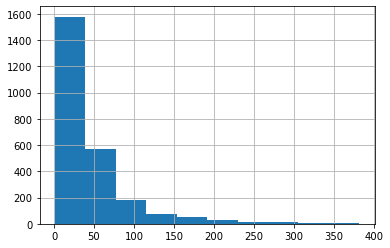

count    2523.000000
mean       44.084423
std        50.691151
min         1.000000
25%        14.000000
50%        29.000000
75%        54.000000
max       382.000000
dtype: float64

In [418]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
encoded_sentences=encode_sentences(text_list)
sentence_len=[len(encoded_sentence) for encoded_sentence in encoded_sentences]
pd.Series(sentence_len).hist()
plt.show()
pd.Series(sentence_len).describe()

In [419]:
features=preprocess(text_list)
train_x=features[:int(0.90*len(features))]
train_y=sentiment_list[:int(0.90*len(features))]
valid_x=features[int(0.90*len(features)):]
valid_y=sentiment_list[int(0.90*len(features)):]
print(len(train_y), len(valid_y))

2270 253


In [420]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_data=TensorDataset(torch.from_numpy(train_x), torch.from_numpy(np.asarray(train_y)))
valid_data=TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(np.asarray(valid_y)))

batch_size=50
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [421]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size())
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 250])
Sample input: 
 tensor([[    0,     0,     0,  ...,  1404,   699,  3833],
        [    0,     0,     0,  ...,   105,  2124,    65],
        [    0,     0,     0,  ...,     2,   574,    48],
        ...,
        [    0,     0,     0,  ..., 10410,   184,   333],
        [    0,     0,     0,  ...,  2200,    13,   105],
        [    0,     0,     0,  ...,     0,     0,    11]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
        2, 1])


In [422]:
import torch.nn as nn
 
class SentimentalLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        self.dropout=nn.Dropout(0.3)
        
        self.fc1=nn.Linear(hidden_dim, 64)
        self.fc2=nn.Linear(64, 16)
        self.fc3=nn.Linear(16,output_size)
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size=x.size()
        
        embedd=self.embedding(x)
        lstm_out, hidden=self.lstm(embedd, hidden)
        
        lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out=self.dropout(lstm_out)
        out=self.fc1(out)
        out=self.dropout(out)
        out=self.fc2(out)
        out=self.dropout(out)
        out=self.fc3(out)
        sig_out=self.sigmoid(out)
        
        sig_out=sig_out.view(batch_size, -1)
        sig_out=sig_out[:, -1]
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [423]:
vocab_size = len(vocab_to_int) + 1 
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentalLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentalLSTM(
  (embedding): Embedding(13539, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [424]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# training params

epochs = 3 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs=inputs.cuda()
            labels=labels.cuda()
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        
        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                inputs, labels = inputs.cuda(), labels.cuda()  
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

IndexError: too many indices for tensor of dimension 2

In [ ]:
def test_model(test_data):
    output_list=list()
    batch_size=50   
    net.eval()
    with torch.no_grad():
        test_review=preprocess(test_data)
        for review in test_review:
            # convert to tensor to pass into your model
            feature_tensor = torch.from_numpy(review).view(1,-1)
            if(train_on_gpu):
                feature_tensor= feature_tensor.cuda()
            batch_size = feature_tensor.size(0)
            # initialize hidden state
            h = net.init_hidden(batch_size)
            # get the output from the model
            output, h = net(feature_tensor, h)
            pred = torch.round(output.squeeze()) 
            output_list.append(pred)
        labels=[int(i.data.cpu().numpy()) for i in output_list]
        return labels
labels=test_model(test_data)

In [ ]:
output = pd.DataFrame()
output['sentiment'] = labels
output